In [1]:
pip install scikit-surprise

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import string 
import datetime
import gzip

from textblob import TextBlob

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

In [4]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [5]:
url_review = '/content/drive/My Drive/Data/steam_reviews.json.gz'
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 15
for l in parse(url_review):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

data_reviews = pd.DataFrame(data_reviews)

In [6]:
url_games = '/content/drive/My Drive/Data/steam_games.json.gz'
data_games = []
for l in parse(url_games):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

https://towardsdatascience.com/steam-recommendation-systems-4358917288eb

https://ansegura7.github.io/RS_Surprise/pages/RS_SVD.html

# Parte A Procesamiento de datos

## Reviews

In [7]:
data_reviews.head(4)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Duha Nubie,11.3,73.0,35140,4,2018-01-03,first debut feel sweet,False,1,NaN,NaN,NaN
2,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
3,S0YxSauCe,0.3,902.0,671270,4,2017-07-10,Easy game. All you have to do is put the hat t...,False,1,NaN,NaN,NaN


In [8]:
data_reviews.shape

(519538, 12)

In [9]:
data_reviews.dtypes

username         object
hours           float64
products        float64
product_id       object
page_order        int64
date             object
text             object
early_access       bool
page              int64
user_id          object
compensation     object
found_funny     float64
dtype: object

In [10]:
#Elimino columnas
data_reviews.drop(['page_order', 'page',
                   'early_access', 'compensation', 'found_funny',
                   'products', 'user_id'],
                   axis=1, inplace=True)

In [11]:
#Convertir a string columnas
columnas = ['username', 'text']
for i in columnas:
  data_reviews[i] = data_reviews[i].astype('string')

#Convertir a int64 columna product_id
data_reviews['product_id'] = data_reviews['product_id'].astype('int64')

#Conversion a tipo datetime64
data_reviews['Fecha'] = pd.to_datetime(data_reviews['date'])
data_reviews['Year'] = data_reviews['Fecha'].dt.year            #Nueva columna con el año del review
data_reviews['month'] = data_reviews['Fecha'].dt.month          #Nueva columna con el mes del review

In [12]:
#Elimino reviews duplicadas del mismo usuario para el mismo videojuego, dejando la mas reciente
data_reviews.drop_duplicates(subset=['username', 'product_id'], keep='first', inplace=True)

In [13]:
def valores_nulos(data):
  print('<-- Porcentaje de valores nulos -->\n')
  print(data.isnull().sum() / data.shape[0] * 100)

In [14]:
valores_nulos(data_reviews)

<-- Porcentaje de valores nulos -->

username      0.000000
hours         0.341593
product_id    0.000000
date          0.000000
text          0.000000
Fecha         0.000000
Year          0.000000
month         0.000000
dtype: float64


 ## Info Games

In [15]:
data_games.shape

(32135, 16)

In [16]:
data_games.dtypes

publisher          object
genres             object
app_name           object
title              object
url                object
release_date       object
tags               object
discount_price    float64
reviews_url        object
specs              object
price              object
early_access         bool
id                 object
developer          object
sentiment          object
metascore          object
dtype: object

In [17]:
#Elimino valores nulos
data_games.dropna(subset=['tags', 'id', 'title'], axis=0, inplace=True)

In [18]:
#Convertir a string columnas
columnas = ['genres', 'title','tags']
for i in columnas:
  data_games[i] = data_games[i].astype('string')

#Convertir a int64 columna product_id
data_games['id'] = data_games['id'].astype('int64')

In [19]:
data_games.drop(['publisher','reviews_url', 'url', 
                 'early_access', 'discount_price', 
                 'app_name', 'release_date',
                 'discount_price', 'specs', 
                 'sentiment', 'metascore'],
                axis=1,
                inplace=True)

In [20]:
valores_nulos(data_games)

<-- Porcentaje de valores nulos -->

genres       3.666076
title        0.000000
tags         0.000000
price        4.103867
id           0.000000
developer    4.087157
dtype: float64


In [21]:
#Tranferencia del Nombre del videojuego segun su id
df = pd.merge(data_reviews, data_games,  left_on='product_id', right_on='id')
df.head(3)

,username,hours,product_id,date,text,Fecha,Year,month,genres,title,tags,price,id,developer
0,Chaos Syren,0.1,725280,2017-12-17,This would not be acceptable as an entertainme...,2017-12-17,2017,12,"['Action', 'Adventure', 'Indie', 'Simulation']",Psi Project,"['Action', 'Adventure', 'Indie', 'Simulation']",2.99,725280,Vyacheslav Shilikhin
1,Duha Nubie,11.3,35140,2018-01-03,first debut feel sweet,2018-01-03,2018,1,"['Action', 'Adventure']",Batman: Arkham Asylum Game of the Year Edition,"['Action', 'Batman', 'Stealth', 'Adventure', '...",19.99,35140,"Rocksteady Studios,Feral Interactive (Mac)"
2,MLGarbage,9.5,35140,2018-01-02,Fun Game. I played shadow of mordor before pla...,2018-01-02,2018,1,"['Action', 'Adventure']",Batman: Arkham Asylum Game of the Year Edition,"['Action', 'Batman', 'Stealth', 'Adventure', '...",19.99,35140,"Rocksteady Studios,Feral Interactive (Mac)"


##Exploración de Información

In [22]:
print('Un total de {} usuarios realizaron reviews de videojuegos'.format(len(df.username.unique())))

Un total de 388027 usuarios realizaron reviews de videojuegos


In [23]:
print("<-- Top 10 de Usuarios con mas reviews -->")
df.username.value_counts().head(10)

<-- Top 10 de Usuarios con mas reviews -->


Alex           119
Nick            99
Jack            96
Chris           85
Dan             76
Saint Aaron     76
123             74
Kodyd194        73
Matt            71
Sam             71
Name: username, dtype: Int64

In [24]:
print('<-- Videojuegos con mas Reviews -->\n')
df.title.value_counts().head(10)

<-- Videojuegos con mas Reviews -->



Team Fortress 2                11731
Rust                            6623
Borderlands 2                   4733
Fallout 4                       4454
Grand Theft Auto V              3901
Portal 2                        3678
Undertale                       3659
DayZ                            3625
Warframe                        3553
Life is Strange - Episode 1     3345
Name: title, dtype: Int64

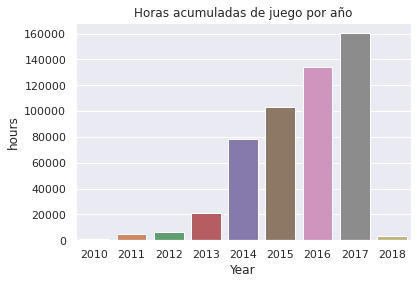

In [25]:
year_review = df.groupby(['Year']).count()
plt.title('Horas acumuladas de juego por año')
sns.barplot(x = year_review.index,
            y=year_review.hours)

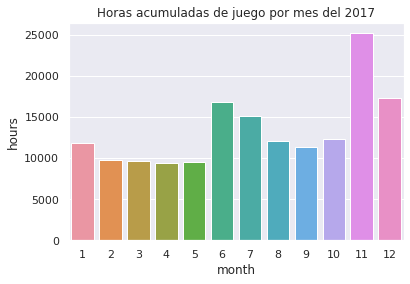

In [26]:
months_2017 = df[df['Year'] == 2017].groupby(['month']).count()
plt.title('Horas acumuladas de juego por mes del 2017')
sns.barplot(x= months_2017.index,
            y=months_2017.hours)

In [27]:
print('<-- Desarrolladores con mas videojuegos registrados -->\n')
data_games.developer.value_counts().head(10)

<-- Desarrolladores con mas videojuegos registrados -->



Ubisoft - San Francisco       1259
SmiteWorks USA, LLC            813
Dovetail Games                 253
KOEI TECMO GAMES CO., LTD.     232
Paradox Development Studio     156
Capcom                         130
Ronimo Games                   123
Choice of Games                100
Stainless Games                 95
Musopia                         95
Name: developer, dtype: int64

In [28]:
print('<-- Desarrolladores con mas reviews -->\n')
df.developer.value_counts().head(10)

<-- Desarrolladores con mas reviews -->



Valve                                       24337
Facepunch Studios                            9733
Bohemia Interactive                          7662
Bethesda Game Studios                        6963
Gearbox Software,Aspyr (Mac &amp; Linux)     4733
Ubisoft Montreal                             4707
Hi-Rez Studios                               4128
Daybreak Game Company                        4051
Rockstar North                               3947
Digital Extremes                             3804
Name: developer, dtype: int64

Text(0, 0.5, 'Frecuencia')

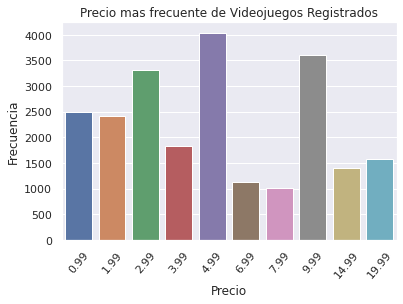

In [29]:
price_games = data_games.price.value_counts().head(10)
sns.barplot(x=price_games.index[0:],
            y=price_games)
plt.title('Precio mas frecuente de Videojuegos Registrados')
plt.xticks(rotation=50)
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

Text(0, 0.5, 'Frecuencia')

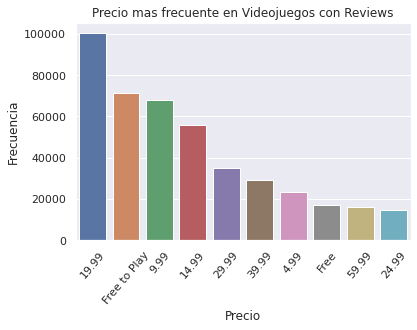

In [30]:
price_games = df.price.value_counts().head(10)
sns.barplot(x=price_games.index[0:],
            y=price_games)
plt.title('Precio mas frecuente en Videojuegos con Reviews')
plt.xticks(rotation=50)
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# Recomendaciones

Este sistema de recomendación se basa en la similitud del genero del videojuego del cual se realiza la review

In [31]:
#Submuestra
df_games = data_games.sample(frac=0.04)
df_games.reset_index(drop=True, inplace=True)

df_reviews = data_reviews.sample(frac=0.04)
df_reviews.reset_index(drop=True, inplace=True)

In [32]:
 #df_games['tags'] = df_games['tags'].fillna(' ')
 df_games['xtags'] = df_games['tags'].str.replace('[{}]'.format(string.punctuation), ' ')

In [33]:
break

SyntaxError: ignored

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')        #Defino las stopwords
tfidf = TfidfVectorizer(stop_words=set(stopwords))        #Defino el modelo
tfidf_matrix = tfidf.fit_transform(df_games['xtags'])   #Creo matriz

In [ ]:
'''
Matriz de comparación
Compara las etiquetas de un video seleccionado con la lista anterior
en busca de palabras similares
'''
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
print(len(tfidf.vocabulary_))
print(tfidf_matrix.shape)

In [ ]:
indices = pd.Series(df_games.index, index=df_games['title']).drop_duplicates()

In [ ]:
def get_recomendation(title, cosine_sim=cosine_sim):
    idx = indices[title]                                                        #Selecciona el titulo del videojuego                        
    sim_scores = list(enumerate(cosine_sim[idx]))                               
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)           #Ordena de mayor a menor las similitudes
    sim_scores = sim_scores[1:6]                                                #Selecciona las primero 5 similitudes
    games_indices = [i[0] for i in sim_scores]
    return df_games['title'].iloc[games_indices]                                #Retorna el nombre de los videojuegos

In [ ]:
def recomendation():
  '''
  Se seleccionara un id de un videojuego al azar, simulando que el usuario ya selecciono
  el videojuego que va jugar y escribir su reseña'''
  ids  = np.random.randint(df_games.shape[0])                         #Obtiene una linea al azar
  ids  = df_games.id.iloc[ids]                                        #Obtiene el id del videojuego seleccionado al azar
  name = (df_games.loc[df_games['id'] == ids]['title']).iloc[0]       #Busca el nombre del id del videojuego 
  print('Usted ha jugado: {}'.format(name))
  input('Ingrese su reseña: ')
  print('\nNuestras recomendaciones basadas en su ultima review:')
  print(get_recomendation(name))

In [ ]:
recomendation()

# Procesamiento de lenguaje natural

Realizo procesamiento de lenguaje, para intentar obtener una calificacion a la review realizada por el usuario , obteniendo una calificacion para la polaridad del comentario.
Si el comentario es positivo, el valor sera igual o cercano a 1, mientras, que, si el comentario es negativo, el valor sera igual o cercano a -1, si el comentario es neutro el valor sera cercano o igual a 0

In [34]:
df.head(2)

,username,hours,product_id,date,text,Fecha,Year,month,genres,title,tags,price,id,developer
0,Chaos Syren,0.1,725280,2017-12-17,This would not be acceptable as an entertainme...,2017-12-17,2017,12,"['Action', 'Adventure', 'Indie', 'Simulation']",Psi Project,"['Action', 'Adventure', 'Indie', 'Simulation']",2.99,725280,Vyacheslav Shilikhin
1,Duha Nubie,11.3,35140,2018-01-03,first debut feel sweet,2018-01-03,2018,1,"['Action', 'Adventure']",Batman: Arkham Asylum Game of the Year Edition,"['Action', 'Batman', 'Stealth', 'Adventure', '...",19.99,35140,"Rocksteady Studios,Feral Interactive (Mac)"


In [35]:
df.drop(['hours', 'date', 'Fecha', 'Year', 'month', 'developer', 'price','id'], axis=1, inplace=True)

## Estandarizar el texto

In [36]:
 #Elimino signos de puntuacion
 df['xtext'] = df['text'].str.replace('[{}]'.format(string.punctuation), ' ')

## Conversion de nombre de usuarios a numeros

In [37]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df['username'])
df['x_username'] = le.transform(df['username'])

df.head(2)

,username,product_id,text,genres,title,tags,xtext,x_username
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,"['Action', 'Adventure', 'Indie', 'Simulation']",Psi Project,"['Action', 'Adventure', 'Indie', 'Simulation']",This would not be acceptable as an entertainme...,45116
1,Duha Nubie,35140,first debut feel sweet,"['Action', 'Adventure']",Batman: Arkham Asylum Game of the Year Edition,"['Action', 'Batman', 'Stealth', 'Adventure', '...",first debut feel sweet,73962


In [38]:
#Submuestra
df_sub= df.sample(frac=0.1)
df_sub.reset_index(drop=True, inplace=True)

## Emojis

In [ ]:
pip install emoji

In [ ]:
#Elimino cualquier emoji presente en la review escrita
import emoji

In [ ]:
df_reviews.xtext.iloc[1]

In [ ]:
#df_reviews['xtext'] = emoji.demojize(df_reviews['xtext'])

## Traduccion de comentario

In [ ]:
#df_reviews['xtext'] = df_reviews['text'].apply(lambda x: TextBlob(x).translate(to='en'))

In [ ]:
#Ya que todos los comentarios se encuentran en ingles, la celda anterior marca error, ya que no tiene acciones por realizar

## Polaridad y subjetividad de reviews

In [ ]:
#Correcion de escritura
#correciones = []
#for i in range(df_sub.shape[0]):
#  correcion = df_sub.xtext.iloc[i]
#  correcion = TextBlob(correcion).correct()
#  correciones.append(correcion)
#df_sub['xtext'] = correciones

In [ ]:
#TextBlob(comentario).sentimen

In [39]:
#Creacion de una nueva columna con la polaridad de la review
comentarios = []

for i in range(df_sub.shape[0]):
  comentario = df_sub.xtext.iloc[i]
  comentario = TextBlob(comentario).polarity
  comentarios.append(comentario)

df_sub['polarity'] = comentarios

In [40]:
#Creacion de una nueva columna con la subjetividad de la revoew
comentarios = []

for i in range(df_sub.shape[0]):
  comentario = df_sub.xtext.iloc[i]
  comentario = TextBlob(comentario).subjectivity
  comentarios.append(comentario)

df_sub['subjectivity'] = comentarios

## Analisis de comentarios

In [41]:
df_sub.head(2)

,username,product_id,text,genres,title,tags,xtext,x_username,polarity,subjectivity
0,River & Johnny,4000,its fun i guess,"['Indie', 'Simulation']",Garry's Mod,"['Sandbox', 'Multiplayer', 'Funny', 'Moddable'...",its fun i guess,205211,0.3,0.2
1,sad piece of shit,306130,go ♥♥♥♥ you self i cant buy dlc for this game,"['Massively Multiplayer', 'RPG']",The Elder Scrolls® Online: Tamriel Unlimited™,"['RPG', 'Open World', 'MMORPG', 'Massively Mul...",go ♥♥♥♥ you self i cant buy dlc for this game,352056,-0.4,0.4


In [42]:
print('<-- Videojuegos con más reviews positivas-->\n')
df_sub.groupby('title')['polarity'].mean().sort_values(ascending=False).head()

<-- Videojuegos con más reviews positivas-->



title
DRAGON BALL Xenoverse 2 - Steve Aoki Pack    1.0
Croixleur Sigma                              1.0
Tap Tap Infinity                             1.0
Gravi                                        1.0
Over The Void                                1.0
Name: polarity, dtype: float64

In [43]:
#Data de videojuego con el promedio de polaridad en sus reviews
ratings = pd.DataFrame(df_sub.groupby('title')['polarity'].mean())
ratings.head()

,polarity
title,
&gt;observer_,0.063423
- Arcane RERaise -,-0.288889
- Arcane Raise -,-0.101481
.hack//G.U. Last Recode,0.290690
//N.P.P.D. RUSH//- The milk of Ultraviolet,-0.019547


In [44]:
#Nueva columna, el numero de reviews recibidas por videojuego
ratings['num of ratings'] = pd.DataFrame(df_sub.groupby('title')['polarity'].count())
ratings.head()

,polarity,num of ratings
title,,
&gt;observer_,0.063423,2
- Arcane RERaise -,-0.288889,1
- Arcane Raise -,-0.101481,1
.hack//G.U. Last Recode,0.290690,3
//N.P.P.D. RUSH//- The milk of Ultraviolet,-0.019547,4


Text(0.5, 1.0, "Polaridad de Review's")

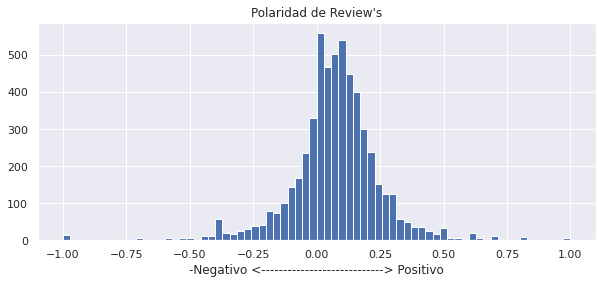

In [45]:
plt.figure(figsize=(10,4))
ratings['polarity'].hist(bins=70)
plt.xlabel('-Negativo <----------------------------> Positivo')
plt.title("Polaridad de Review's")

# Machine Learning
## Surprise

In [68]:
#Creo una copia de las review, que mas adelante empleare
calificaciones = df_sub[['x_username', 'product_id', 'polarity']]

In [ ]:
calificaciones


###Intento nuevo

https://ansegura7.github.io/RS_Surprise/pages/RS_SVD.html

In [70]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(calificaciones, test_size = 0.2)

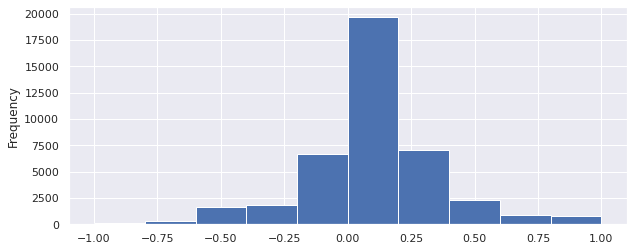

In [71]:
plt.figure(figsize = (10, 4))
train_data.polarity.plot.hist(bins = 10)
plt.show()

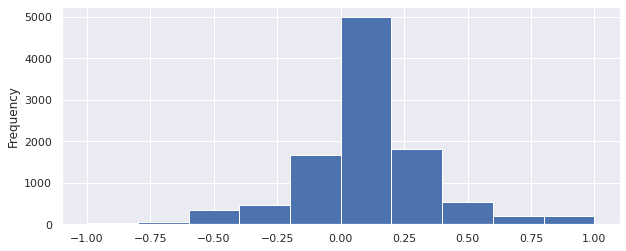

In [72]:
plt.figure(figsize = (10, 4))
test_data.polarity.plot.hist(bins = 10)
plt.show()

In [73]:
reader = Reader(rating_scale = (-1.00, 1.00))
data_train = Dataset.load_from_df(train_data[['x_username', 'product_id', 'polarity']], reader)
data_test = Dataset.load_from_df(test_data[['x_username', 'product_id', 'polarity']], reader)

In [74]:
# Build full trainset
data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

In [75]:
print('Train rating', data_train.global_mean)
print('Test rating', data_test.global_mean)

Train rating 0.0964195909706116
Test rating 0.09610437244455755


In [76]:
# Create the trainset and testset
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

In [77]:
# Create SVD algorithm with 5 factors
from surprise import SVD
k_factors = 5
algo = SVD(n_factors= k_factors, n_epochs= 200, biased= True, lr_all= 0.005, reg_all= 0, init_mean= 0, init_std_dev= 0.01)

In [79]:
algo.fit(data_train)

In [80]:
# Calculate RMSE for training dataset
from surprise import accuracy
train_pred = algo.test(data_trainset)
accuracy.rmse(train_pred)

RMSE: 0.0969


0.09687541451994693

In [81]:
# Calculate RMSE for test dataset
test_pred = algo.test(data_testset)
accuracy.rmse(test_pred)

RMSE: 0.2613


0.26133519089687013

In [82]:
train_data.head(5)

,x_username,product_id,polarity
33389,9141,440,0.375556
51054,189545,207230,-0.017143
8872,368795,315430,0.026667
47172,86121,365590,-0.100000
9308,215090,271590,0.364286


In [83]:
# Prediction without real rating
p1 = algo.predict(uid = train_data.iloc[0].x_username, iid = train_data.iloc[0].product_id, verbose = True)

user: 9141.0     item: 440.0      r_ui = None   est = 0.36   {'was_impossible': False}


In [84]:
test_data.head(5)

,x_username,product_id,polarity
24128,240456,220240,0.034615
2617,310160,65980,-0.143576
15611,66684,213670,0.055769
19706,343227,301520,0.228350
13281,346622,50300,-0.400000


In [85]:
# Prediction with real rating
p2 = algo.predict(uid = 240456, iid = 220240, r_ui = 0.034615, verbose = True)

user: 240456     item: 220240     r_ui = 0.03   est = 0.08   {'was_impossible': False}


## Optimizacion de Hyperparametros

In [90]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_factors': [5,50,100],
    'n_epochs' : [50,100,150,200],
    'lr_all'   : [0.001, 0.002, 0.005],
    'reg_all'  : [0, 0.002, 0.02, 0.2],
    'biased'   : [True,False],
    'init_mean': [0],
    'init_std_dev': [0.01]
    }
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs = -1)
gs.fit(data_trainset)

AttributeError: ignored

In [ ]:
data = pd.read

In [ ]:
  from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

In [ ]:
#Defino el modelo reader
reader = Reader()

#Creo Dataset para el modelo
N_filas = 2000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(calificaciones[['username', 'product_id', 'polarity']][:N_filas], reader)

In [ ]:
from surprise import SVD
algo = SVD()

In [ ]:
from surprise.model_selection.validation import cross_validate
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
#Division de Datos de entrenamiento y test
trainset, testset = train_test_split(data, test_size=.25)

In [ ]:
#Entreno modelo
algo.fit(trainset)

In [ ]:
usuario = df_sub[df_sub['username'] == '123']

In [ ]:
#Uso el usuario con mas reviews para emplear una prediccion usuario='123'
usuario['estimate_escore'] = usuario['product_id'].apply(lambda x: algo.predict('123', x).est)

In [ ]:
usuario.head(4)

In [ ]:
print('Calificacion maxima asiganada por el modelo: ',usuario.estimate_escore.max())
print('Calificacion minima asiganada por el modelo: ', usuario.estimate_escore.min())

El modelo asigna 1 a todos los videojuegos, lo cual se traduce como si le gustaran todos los videojuegos

In [ ]:
#Realizo predicciones
predictions = algo.test(testset)

In [ ]:
#Explorar predicciones
predictions[3]

In [ ]:
df[df['username'] == '123'].head(2)

In [ ]:
df_reviews[df_reviews['username'] == '123']

In [ ]:
#Prediccion
algo.predict('123', '405500')

In [ ]:
#Selecciono el usuario con mas reviews
calificaciones[calificaciones['username'] == '123']

In [ ]:
usuario = '123'  
polariy = -1.0
df_user = df_reviews[(df_reviews['username'] == usuario) & (df_reviews['polariy'] >= polariy)]
df_user.reset_index(drop=True, inplace=True)
names = []
for i in df_user.product_id:
  name = data_games[data_games['id'] == i]
  name = name.title.values[0]
  names.append(name)


df_user['game_name'] = names

In [ ]:
df_user

In [ ]:
#Creo una copia del Dataser donde se encuentran todos los juegos registrados
recomendaciones_games = data_games.iloc[0:]

In [ ]:
#Juegos que el usuario ya jugo"
juegos_jugados = data_reviews[data_reviews['username'] == usuario]
#Elimino los juegos que tienen mas de 1 review para el mismo usuario, conservando la ultima review
juegos_jugados.drop_duplicates(subset='product_id',keep='first', inplace=True)
print('El usuario ya ha jugado',juegos_jugados.shape[0],'videojuegos\n')
juegos_jugados.head(3)

In [ ]:
#Elimino los juegos que el usuario ya ha jugado
for i in juegos_jugados.product_id:
  id = i
  recomendaciones_games.drop(recomendaciones_games[recomendaciones_games['id'] == id ].index, inplace=True)

In [ ]:
recomendaciones_games.head(2)

In [ ]:
usuario

In [ ]:
#Realizo predicciones sobre de posible positividads
recomendaciones_games['Score_estimate'] = recomendaciones_games['id'].apply(lambda x:algo.predict(usuario, x).est)

In [ ]:
recomendaciones_games.Score_estimate.max()

In [ ]:
from surprise import accuracy

accuracy.rmse(predictions)

In [ ]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

In [ ]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)


In [ ]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

# Prueba Nuevo Filtro

## Sistema Recomendación

# Recomendaciones basadas en calificaciones

In [ ]:
df_sub.head(2)

In [ ]:
df_sub.drop(columns=['text'], inplace=True)

In [ ]:
df_sub.shape

In [ ]:
gamemat = df_sub.pivot_table(index='username',columns='title',values='polarity')
gamemat.head()

In [ ]:
#Elimino videojuegos con menos de 20 reviews
gamemat = gamemat.dropna(thresh=30, axis=1).fillna(0,axis=1)

In [ ]:
corrMatrix = gamemat.corr(method='pearson')
corrMatrix.head(10)

In [ ]:
def get_similar(game_name,rating):
    similar_ratings = corrMatrix[game_name]*(rating-2.5)
    similar_ratings = similar_ratings.sort_values(ascending=False)
    #print(type(similar_ratings))
    return similar_ratings

In [ ]:
games = [("Call of Duty®: Modern Warfare® 2",.6), ("Euro Truck Simulator 2",0),
                  ("Battlefield: Bad Company™ 2",1),("Life is Strange - Episode 1",-0.6)]
similar_games = pd.DataFrame()
for game,rating in games:
    similar_games = similar_games.append(get_similar(game,rating),ignore_index = True)

similar_games.head(10)

In [ ]:
similar_games.sum().sort_values(ascending=False).head(20)

In [ ]:
games = [("Call of Duty®: Modern Warfare® 2",0.6),("Battlefield: Bad Company™ 2",1)]
similar_games = pd.DataFrame()
for game,rating in games:
    similar_games = similar_games.append(get_similar(game,rating),ignore_index = True)

similar_games.head(10)

In [ ]:
similar_games.sum().sort_values(ascending=False).head(20)

In [ ]:
x = similar_games.sum().sort_values(ascending=False).head(20)

In [ ]:
x = x.to_frame()
x

In [ ]:
usuario = df_sub[df_sub['username'] == '123']
usuario.head(1)

In [ ]:
usuario.shape

In [ ]:
x.shape

In [ ]:
#Elimino los juegos que el usuario ya ha jugado
for i in x.index:
  name = i
  x.drop(usuario[usuario['title'] == name ].index, inplace=True)

In [ ]:
x.shape

In [ ]:
def get_random_game():
  all_games = data_games[['id', 'title']]
  x = int(np.random.randint(df_sub.shape[0], size=1))
  x = df_sub.username.iloc[x]
  usuario = df[df['username'] == x]
  print('--> El usuario ha jugado: ',usuario.shape[0], 'videojuegos')
  for i in usuario.title:
    game = i
    all_games.drop(all_games[all_games['title'] == game ].index, inplace=True)
    
  game = df_sub.title.iloc[int(np.random.randint(df_sub.shape[0], size=1))]
  print(' * Videjuego seleccionado:', game)

  rating = str(input('--> Ingrese la review del videojuego: '))
  rating = TextBlob(rating).polarity

  similar_games = pd.DataFrame()
  similar_games = similar_games.append(get_similar(game,rating),ignore_index = True)
  x = similar_games.sum().sort_values(ascending=False).head(10)

  #Elimino los juegos que el usuario ya ha jugado
  for i in x.index:
    name = i
    usuario.drop(usuario[usuario['title'] == name ].index, inplace=True)

  print('<------------------------->')
  print("Nuestra recomendaciones para usted: \n")
  for i in x.index:
    print(i)

In [ ]:
get_random_game()

Falta emplear un dataframe en donde solo se encuentren los viejuegos con reviews mayores a 30 aparciciones